In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# load data menjadi data frame
df = pd.read_csv('measurement_datamart.csv')

In [3]:
# cek data duplikat
print(df.duplicated().sum())

0


In [3]:
# drop kolom yg tidak terpakai
df.drop(['Measurement_time', 'Station code', 'Address', 'Latitude',
           'Longitude', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], axis=1, inplace=True)

In [4]:
# ubah type data Measurement_date menjadi datetime
df['Measurement_date'] = pd.to_datetime(df['Measurement_date'])

In [5]:
df['End_of_month'] = df['Measurement_date'] + pd.offsets.MonthEnd(0)

In [7]:
df.head(5)

,Measurement_date,District,AQI_index,AQI_category,End_of_month
0,2017-01-01,Jongno-gu,94.9,Satisfactory,2017-01-31
1,2017-01-01,Jongno-gu,98.3,Satisfactory,2017-01-31
2,2017-01-01,Jongno-gu,98.3,Satisfactory,2017-01-31
3,2017-01-01,Jongno-gu,96.6,Satisfactory,2017-01-31
4,2017-01-01,Jongno-gu,101.0,Moderate,2017-01-31


In [6]:
# filter hanya mengambil 1 distrik 
jongno = df[df['District'] == 'Jongno-gu']

In [7]:
# group by date dan ambil min max AQI harian
df = jongno.groupby('End_of_month')['AQI_index'].agg(['max', 'min', 'mean']).reset_index()
df.columns = ['Date', 'Max_AQI', 'Min_AQI', 'Avg_AQI']

In [8]:
# ubah kolom Measurement_date menjadi index
df = df.set_index('Date') 

In [9]:
df.head(5)

,Max_AQI,Min_AQI,Avg_AQI
Date,,,
2017-01-31,530.0,1.7,63.600134
2017-02-28,463.0,-1.7,50.037202
2017-03-31,336.3,6.7,70.626210
2017-04-30,455.0,-1.7,44.224583
2017-05-31,193.2,-1.7,38.090591


## Data Time Series

<Axes: xlabel='Date'>

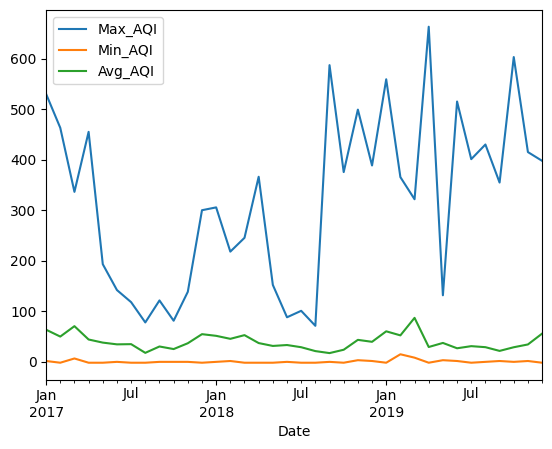

In [10]:
df[['Max_AQI', 'Min_AQI', 'Avg_AQI']].plot()

# Time Series Decompotion

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Max_AQI


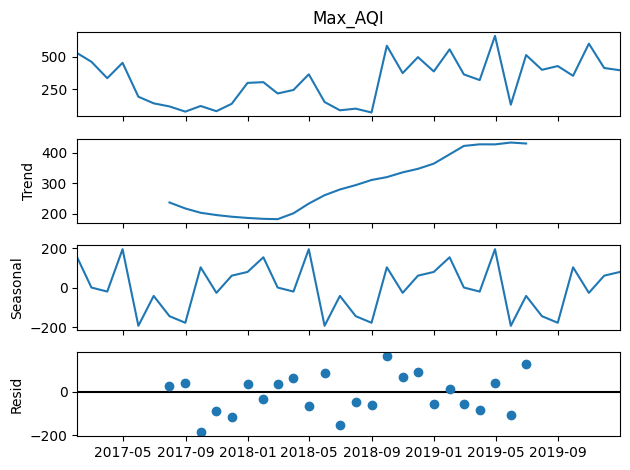

In [12]:
res = seasonal_decompose(df['Max_AQI'], model='additive')
ax=res.plot()
plt.show()

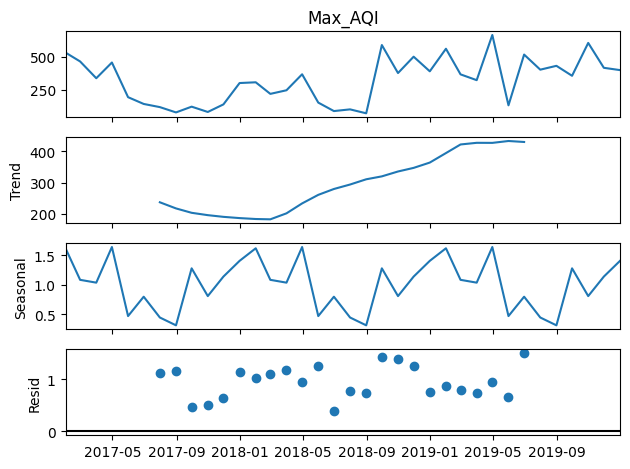

In [13]:
res = seasonal_decompose(df['Max_AQI'], model='multiplicative')
ax=res.plot()
plt.show()

In [15]:
seasonal_max = res.seasonal[res.seasonal==res.seasonal.max()].reset_index()
seasonal_min = res.seasonal[res.seasonal==res.seasonal.min()].reset_index()
seasonal_max.head()

,Date,seasonal
0,2017-04-30,1.637984
1,2018-04-30,1.637984
2,2019-04-30,1.637984


In [16]:
seasonal_max['Date'].head()

0   2017-04-30
1   2018-04-30
2   2019-04-30
Name: Date, dtype: datetime64[ns]

In [17]:
seasonal_min['Date'].head()

0   2017-08-31
1   2018-08-31
2   2019-08-31
Name: Date, dtype: datetime64[ns]

## Min_AQI

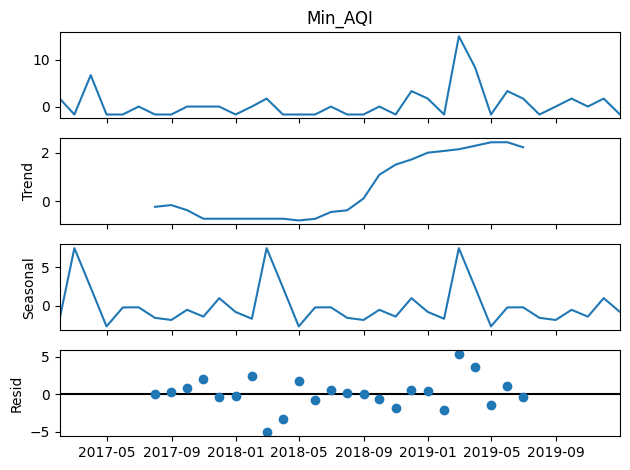

In [14]:
res = seasonal_decompose(df['Min_AQI'], model='additive', period=12)
ax=res.plot()
plt.show()

In [19]:
seasonal_max = res.seasonal[res.seasonal==res.seasonal.max()].reset_index()
seasonal_min = res.seasonal[res.seasonal==res.seasonal.min()].reset_index()
seasonal_max.head()

,Date,seasonal
0,2017-02-28,7.485938
1,2018-02-28,7.485938
2,2019-02-28,7.485938


In [20]:
seasonal_max['Date'].head()

0   2017-02-28
1   2018-02-28
2   2019-02-28
Name: Date, dtype: datetime64[ns]

In [21]:
seasonal_min['Date'].head()

0   2017-04-30
1   2018-04-30
2   2019-04-30
Name: Date, dtype: datetime64[ns]

## Avg_AQI

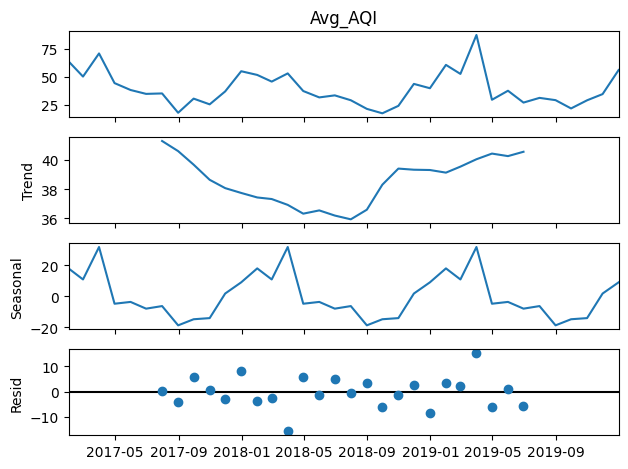

In [15]:
res = seasonal_decompose(df['Avg_AQI'], model='additive', period=12)
ax=res.plot()
plt.show()

In [23]:
seasonal_max = res.seasonal[res.seasonal==res.seasonal.max()].reset_index()
seasonal_min = res.seasonal[res.seasonal==res.seasonal.min()].reset_index()
seasonal_max.head()

,Date,seasonal
0,2017-03-31,31.682459
1,2018-03-31,31.682459
2,2019-03-31,31.682459


In [24]:
seasonal_max['Date'].head()

0   2017-03-31
1   2018-03-31
2   2019-03-31
Name: Date, dtype: datetime64[ns]

In [25]:
seasonal_min['Date'].head()

0   2017-08-31
1   2018-08-31
2   2019-08-31
Name: Date, dtype: datetime64[ns]

## Data stationer


In [16]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

### Max_AQI

In [17]:
check_stationarity(df['Max_AQI'])

ADF Statistic: -2.229159
p-value: 0.195833
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Non-stationary


In [18]:
diff1 = df['Max_AQI'].diff()

In [19]:
check_stationarity(diff1.dropna())

ADF Statistic: -3.686455
p-value: 0.004308
Critical Values:
	1%: -3.700
	5%: -2.976
	10%: -2.628
Stationary


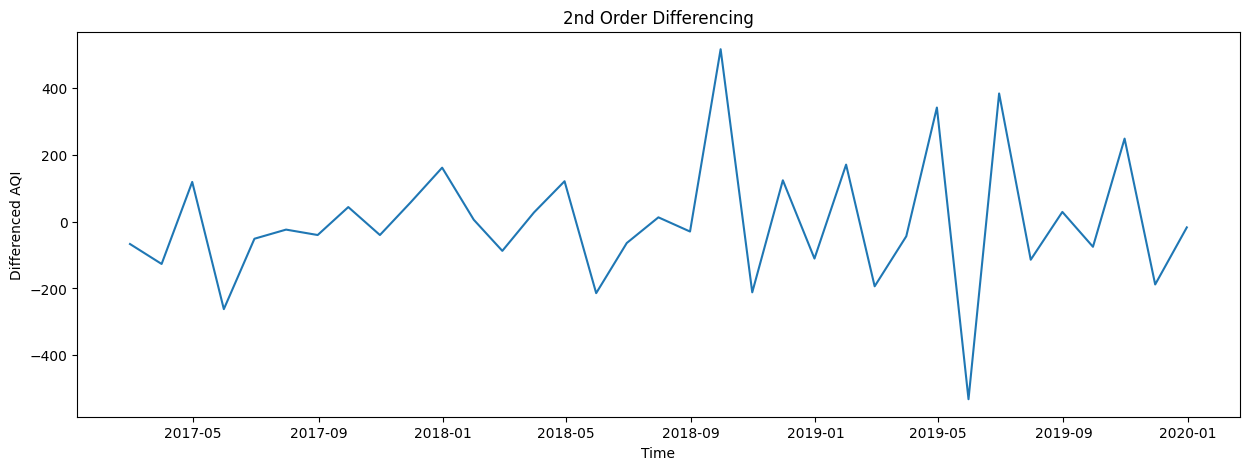

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('2nd Order Differencing')
ax.plot(df['Max_AQI'].diff())  # 2nd order differencing
ax.set_ylabel('Differenced AQI')
ax.set_xlabel('Time')
plt.show()

### Min_AQI

In [21]:
check_stationarity(df['Min_AQI'])

ADF Statistic: -2.165418
p-value: 0.219035
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Non-stationary


In [22]:
diff1 = df['Min_AQI'].diff()

In [23]:
check_stationarity(diff1.dropna())

ADF Statistic: -9.023818
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Stationary


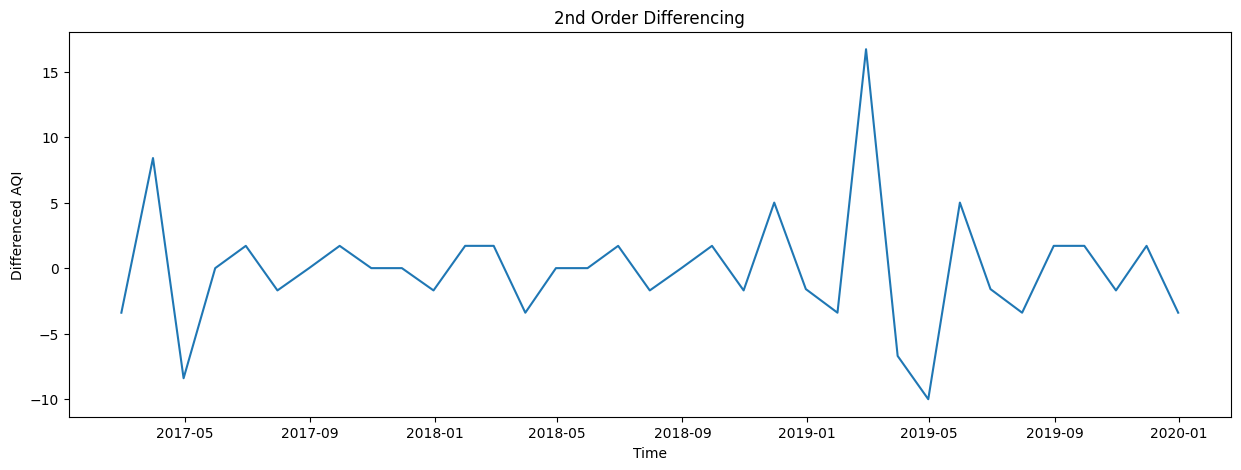

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('2nd Order Differencing')
ax.plot(df['Min_AQI'].diff())  # 2nd order differencing
ax.set_ylabel('Differenced AQI')
ax.set_xlabel('Time')
plt.show()

## Avg_AQI

In [25]:
check_stationarity(df['Avg_AQI'])

ADF Statistic: -4.608194
p-value: 0.000125
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
Stationary


# Model definiton and training

In [ ]:
df['Max_AQI'].asfreq('M')

In [30]:
df.iloc[-1,:]

Max_AQI    50.0
Min_AQI    20.0
Name: 2019-12-31 00:00:00, dtype: float64

In [26]:
data_series = df['Max_AQI'].asfreq('M')

# SARIMA order = (p,d,q), seasonal_order = (P,D,Q,s)
model = SARIMAX(data_series,
                order=(0, 1, 0),
                seasonal_order=(0, 1, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)

print('AIC:', result.aic)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\1205937146.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_series = df['Max_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


AIC: 143.7738536826705


In [27]:
data_series = df['Min_AQI'].asfreq('M')

# SARIMA order = (p,d,q), seasonal_order = (P,D,Q,s)
model = SARIMAX(data_series,
                order=(0, 1, 0),
                seasonal_order=(0, 1, 1, 12),  
                enforce_invertibility=False)

result = model.fit(disp=False)

print('AIC:', result.aic)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\1552150633.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_series = df['Min_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


AIC: 147.1882600344079


In [28]:
data_series = df['Avg_AQI'].asfreq('M')

# SARIMA order = (p,d,q), seasonal_order = (P,D,Q,s)
model = SARIMAX(data_series,
                order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)

print('AIC:', result.aic)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\419307991.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_series = df['Avg_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


AIC: 86.50680276632491


# Model Evaluation

In [29]:
y_pred = result.predict(start=0, end=len(df)-1)

mse = mean_squared_error(df['Max_AQI'], y_pred)
mae = mean_absolute_error(df['Max_AQI'], y_pred)

print('MSE:', mse)
print('MAE:', mae)

MSE: 114659.58866883499
MAE: 294.6297907564653


In [30]:
y_pred = result.predict(start=0, end=len(df)-1)

mse = mean_squared_error(df['Min_AQI'], y_pred)
mae = mean_absolute_error(df['Min_AQI'], y_pred)

print('MSE:', mse)
print('MAE:', mae)

MSE: 1166.0847730315108
MAE: 27.971878040244555


In [31]:
y_pred = result.predict(start=0, end=len(df)-1)

mse = mean_squared_error(df['Avg_AQI'], y_pred)
mae = mean_absolute_error(df['Avg_AQI'], y_pred)

print('MSE:', mse)
print('MAE:', mae)

MSE: 873.0332023022804
MAE: 20.54934440741997


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\246201852.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Max_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


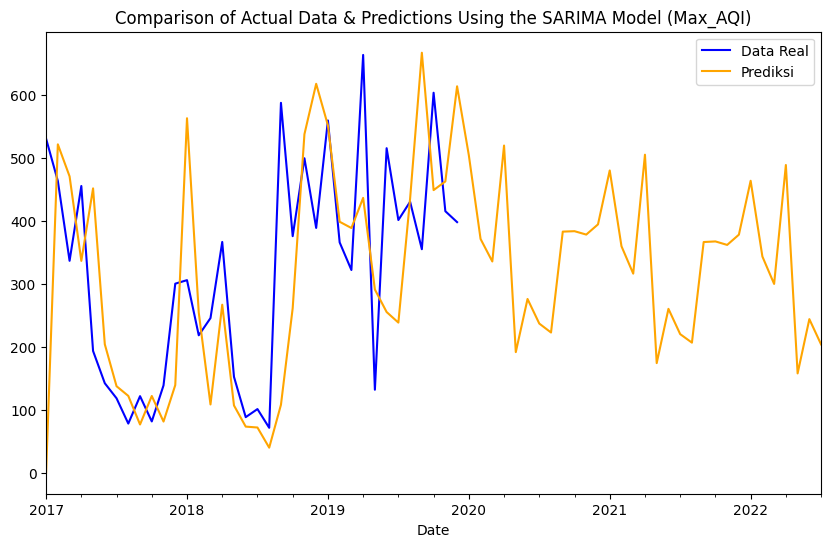

In [32]:
data_monthly = df ['Max_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Max_AQI)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\2276982671.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Min_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


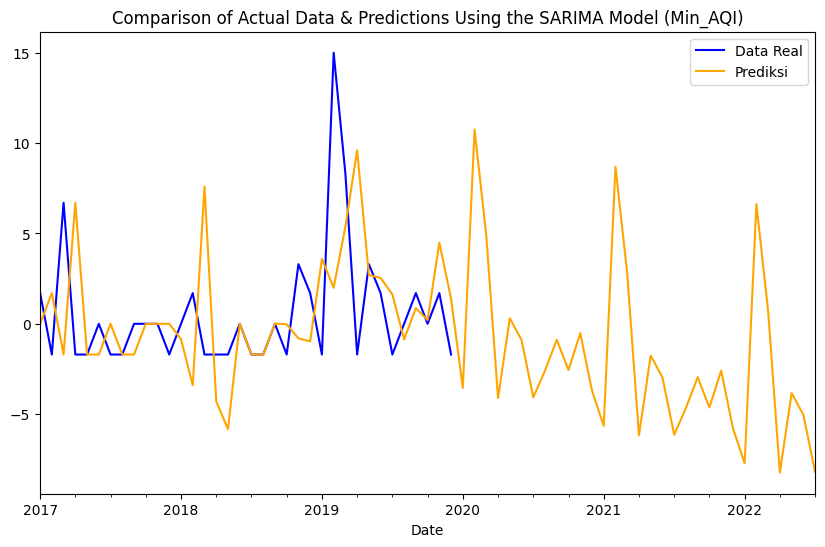

In [33]:
data_monthly = df ['Min_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Min_AQI)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\2097603650.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Avg_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


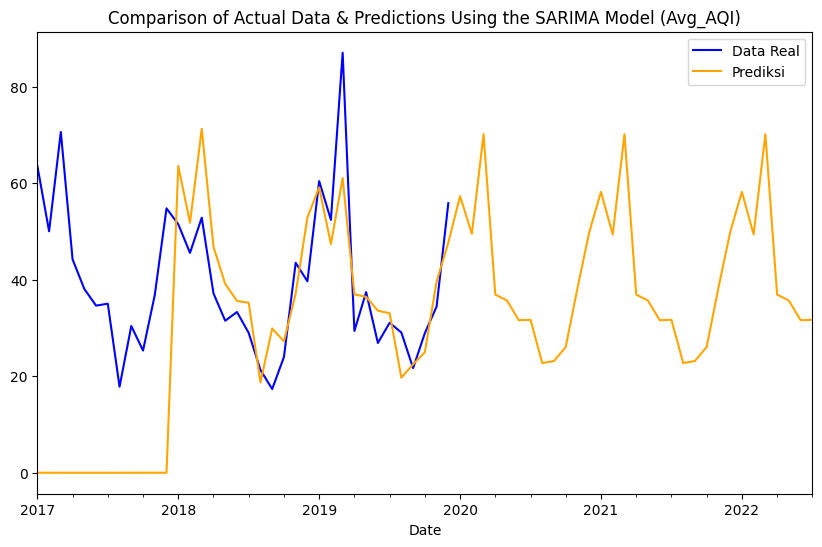

In [34]:
data_monthly = df ['Avg_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Avg_AQI)')
plt.show()

# Fine Tuning


In [35]:
def find_best_sarima_model(data, num_p, num_d, num_q, num_P, num_D, num_Q, m):
    df_result = pd.DataFrame()
    pdq = []
    seasonal_pdq = []
    aic_scores = []

    for p in range(num_p + 1):
        for d in range(num_d + 1):
            for q in range(num_q + 1):
                for P in range(num_P + 1):
                    for D in range(num_D + 1):
                        for Q in range(num_Q + 1):
                            try:
                                model = SARIMAX(data,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, m),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                result = model.fit(disp=False)

                                pdq.append((p, d, q))
                                seasonal_pdq.append((P, D, Q, m))
                                aic_scores.append(result.aic)
                            except:
                                continue

    df_result['pdq'] = pdq
    df_result['seasonal_pdq'] = seasonal_pdq
    df_result['AIC'] = aic_scores

    df_result.sort_values('AIC', inplace=True)

    best_pdq = df_result.pdq.iloc[0]
    best_seasonal_pdq = df_result.seasonal_pdq.iloc[0]
    best_aic = df_result.AIC.iloc[0]

    return best_pdq, best_seasonal_pdq, best_aic, df_result


In [ ]:
data_monthly = df['Max_AQI'].asfreq('M').fillna(method='ffill')

best_pdq, best_seasonal_pdq, best_aic, tuning_result = find_best_sarima_model(
    data_monthly,
    num_p=2, num_d=1, num_q=2,
    num_P=2, num_D=1, num_Q=2,
    m=12
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\125162763.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df['Max_AQI'].asfreq('M').fillna(method='ffill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11816\125162763.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_monthly = df['Max_AQI'].asfreq('M').fillna(method='ffill')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will 

In [156]:
print("Best non-seasonal order (p,d,q):", best_pdq)
print("Best seasonal order (P,D,Q,m):", best_seasonal_pdq)
print("Best AIC:", best_aic)


Best non-seasonal order (p,d,q): (0, 1, 2)
Best seasonal order (P,D,Q,m): (0, 1, 1, 12)
Best AIC: 110.38586220204118


In [157]:
data_monthly = df['Min_AQI'].asfreq('M').fillna(method='ffill')

best_pdq, best_seasonal_pdq, best_aic, tuning_result = find_best_sarima_model(
    data_monthly,
    num_p=2, num_d=1, num_q=2,
    num_P=1, num_D=1, num_Q=1,
    m=12
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13928\2473825445.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df['Min_AQI'].asfreq('M').fillna(method='ffill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13928\2473825445.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_monthly = df['Min_AQI'].asfreq('M').fillna(method='ffill')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observation

In [158]:
print("Best non-seasonal order (p,d,q):", best_pdq)
print("Best seasonal order (P,D,Q,m):", best_seasonal_pdq)
print("Best AIC:", best_aic)


Best non-seasonal order (p,d,q): (1, 1, 2)
Best seasonal order (P,D,Q,m): (1, 1, 1, 12)
Best AIC: 29.7171448833555


In [159]:
data_monthly = df['Avg_AQI'].asfreq('M').fillna(method='ffill')

best_pdq, best_seasonal_pdq, best_aic, tuning_result = find_best_sarima_model(
    data_monthly,
    num_p=2, num_d=1, num_q=2,
    num_P=1, num_D=1, num_Q=1,
    m=12
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13928\262435123.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df['Avg_AQI'].asfreq('M').fillna(method='ffill')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13928\262435123.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_monthly = df['Avg_AQI'].asfreq('M').fillna(method='ffill')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will 

In [160]:
print("Best non-seasonal order (p,d,q):", best_pdq)
print("Best seasonal order (P,D,Q,m):", best_seasonal_pdq)
print("Best AIC:", best_aic)

Best non-seasonal order (p,d,q): (0, 1, 2)
Best seasonal order (P,D,Q,m): (0, 1, 1, 12)
Best AIC: 56.15616967333415


# Model Evaluation jika mengikuti fine tuning



C:\Users\ASUS\AppData\Local\Temp\ipykernel_5692\3928871684.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Max_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


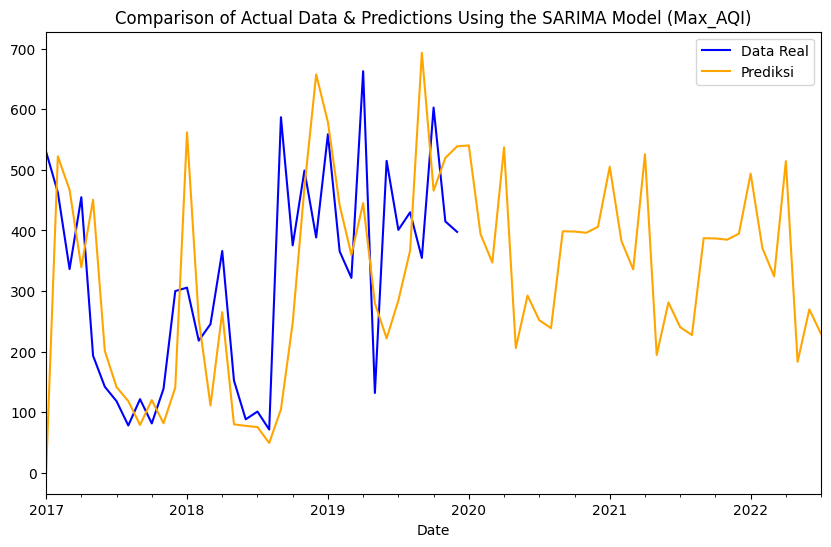

In [48]:
data_monthly = df ['Max_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Max_AQI)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5692\3032479475.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Min_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


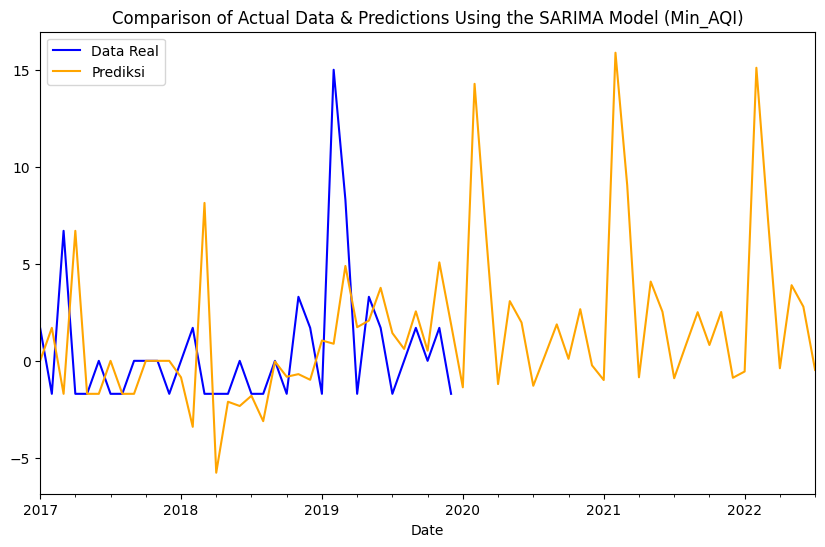

In [49]:
data_monthly = df ['Min_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Min_AQI)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5692\1964742067.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = df ['Avg_AQI'].asfreq('M')
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


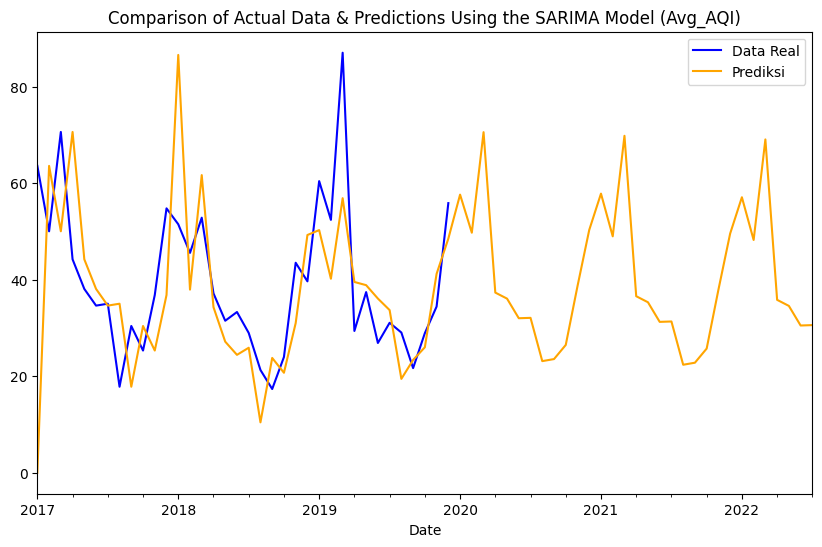

In [50]:
data_monthly = df ['Avg_AQI'].asfreq('M')

model = SARIMAX(data_monthly, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
result = model.fit()

pred_months = result.predict(start=0, end=len(data_monthly)+30)

plt.figure(figsize=(10, 6))
data_monthly.plot(label='Data Real', color='blue')
pred_months.plot(label='Prediksi', color='orange')
plt.legend()
plt.title('Comparison of Actual Data & Predictions Using the SARIMA Model (Avg_AQI)')
plt.show()